# Jupyter notebook sample

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



# Introduction
Finding the optimum time to go to the gym. There's historical time series data about how busy the college gym has been on a 10 minute basis available. We'll find out the best days to go to the gym



In [2]:
gym_data = pd.read_csv('crowdness_gym_data.csv')

In [3]:
print(gym_data.shape)

(62184, 11)


In [52]:
earliest_date = gym_data['date'].min()
latest_date = gym_data['date'].max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

Earliest date: 2015-08-14 17:00:11-07:00
Latest date: 2017-03-18 19:22:51-07:00


In [103]:
# List all unique timezones in the 'date' column
timezones = gym_data['date'].str.extract(r'([+-]\d{2}:\d{2})')[0].unique()
print("Timezones:", timezones)

Timezones: ['-07:00' '-08:00']


The timestamps indicate some daylight savings going on. Let's check that

In [104]:
# Extract the timezone from the 'date' column
gym_data['timezone'] = gym_data['date'].str.extract(r'([+-]\d{2}:\d{2})')[0]

# Detect transitions (where timezone shifts occur)
gym_data['shift'] = gym_data['timezone'] != gym_data['timezone'].shift()

# Get the specific dates where the timezone changes
timezone_shift_dates = gym_data.loc[gym_data['shift'], 'date']
print("Timezone shift dates:")
print(timezone_shift_dates)

Timezone shift dates:
0        2015-08-14 17:00:11-07:00
7638     2015-11-01 01:00:13-08:00
20601    2016-03-13 05:20:11-07:00
51172    2016-11-06 01:01:48-08:00
61519    2017-03-12 17:51:01-07:00
Name: date, dtype: object


In [106]:
# Create a datetime column from the 'date' column
gym_data['datetime'] = pd.to_datetime(gym_data['date'], utc=True)

# Data structure
The dataframe contains 12 columns and about 62184 observations that start mid August 2015 and go to March 2017, but there's clearly some missing data from the start of January 2017 to March 2017 we'll need to address. Finding the start of semester and during semester times is also fairly trivial to perform if we can look up the college semester dates for those years. In this case though, we don't know which college this gym is located at, so we'll need to extract that from existing fields

The real data that's valuable in this data set is the three columns
`number_people`, `date`, `temperature`

Many of the columns are helpful as splitting out data from the date column. We could generate day of week, weekend, holiday, month, hour trivially from the date column. See below
```
# Create new columns from the 'datetime' column
import datetime as dt

gym_data['timestamp'] = gym_data['datetime'].dt.hour * 3600 + gym_data['datetime'].dt.minute * 60 + gym_data['datetime'].dt.second
gym_data['dayofweek'] = gym_data['datetime'].dt.dayofweek
gym_data['is_weekend'] = gym_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
gym_data['month'] = gym_data['datetime'].dt.month
gym_data['hour'] = gym_data['datetime'].dt.hour
```


- **`number_people`**: this is the number of people at the gym at each observation. This will be our target variable or label.
- **`date`**: a string value with the specific date and time information.
- **`timestamp`**: an integer (int), with the number of seconds since the start of the day (00:00).
- **`dayofweek`**: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
- **`is_weekend`**: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
- **`is_holiday`**: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
- **`temperature`**: a float, defining the temperature during the day of the observation in Fahrenheit.
- **`is_start_of_semester`**: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
- **`is_during_semester`**: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
- **`month`**: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
- **`hour`**: an integer (int) for the hour of the day from 0 to 23.

## Semesters
First let's find the start, end and durations of the semesters. This will be important for our analysis, as this is a college gym, many students will return home out of semester time, so gym attendance will drop when they aren't around.

In [5]:
# Resample to daily frequency to get only one observation per day
daily_gym_data = gym_data.resample('D', on='datetime').first()

# Detect start of semesters - the first entry that is true in a series of true.
semester_start_dates = daily_gym_data[
    (daily_gym_data['is_start_of_semester'] == True) &
    (daily_gym_data['is_start_of_semester'].shift(1) != True)
].index

# Calculate semester durations
# The end of the semester is when is_during_semester switches from true to false
semester_durations = []

# Create an object to store semester start and end dates
semester_intervals = []

for start_date in semester_start_dates:
    # Ensure the 'is_during_semester' column is boolean
    is_during_mask = (daily_gym_data.index >= start_date) & (daily_gym_data['is_during_semester'].astype(bool))

    # Find the last day when is_during_semester is True after the start date
    semester_end_date = daily_gym_data[is_during_mask & ~daily_gym_data['is_during_semester'].shift(-1).astype(bool)].index
    if not semester_end_date.empty:
        start = start_date
        end = semester_end_date[0]
        duration = (end - start).days
        semester_durations.append({
            'year': start.year,
            'start_date': start,
            'end_date': end,
            'duration_days': duration
        })

        # Append the start and end dates to the intervals object
        semester_intervals.append((start, end))

# semester_durations can be used for detailed information
# semester_intervals can be used to add features to graphs
semester_durations, semester_intervals

([{'year': 2015,
   'start_date': Timestamp('2015-08-27 00:00:00+0000', tz='UTC'),
   'end_date': Timestamp('2015-12-19 00:00:00+0000', tz='UTC'),
   'duration_days': 114},
  {'year': 2016,
   'start_date': Timestamp('2016-01-18 00:00:00+0000', tz='UTC'),
   'end_date': Timestamp('2016-05-14 00:00:00+0000', tz='UTC'),
   'duration_days': 117},
  {'year': 2016,
   'start_date': Timestamp('2016-08-25 00:00:00+0000', tz='UTC'),
   'end_date': Timestamp('2016-12-17 00:00:00+0000', tz='UTC'),
   'duration_days': 114}],
 [(Timestamp('2015-08-27 00:00:00+0000', tz='UTC'),
   Timestamp('2015-12-19 00:00:00+0000', tz='UTC')),
  (Timestamp('2016-01-18 00:00:00+0000', tz='UTC'),
   Timestamp('2016-05-14 00:00:00+0000', tz='UTC')),
  (Timestamp('2016-08-25 00:00:00+0000', tz='UTC'),
   Timestamp('2016-12-17 00:00:00+0000', tz='UTC'))])

The data covers 3 semesters. The 4th semester that would start in 2017 is missing a lot of data so we'll have to ignore it

# Plotting time series data
We'll smooth the data for temperature and number of people attending. A rolling window of 144 works out to be about a 1 day average, which is good for smaller views, but still a bit busy for a yearlong view

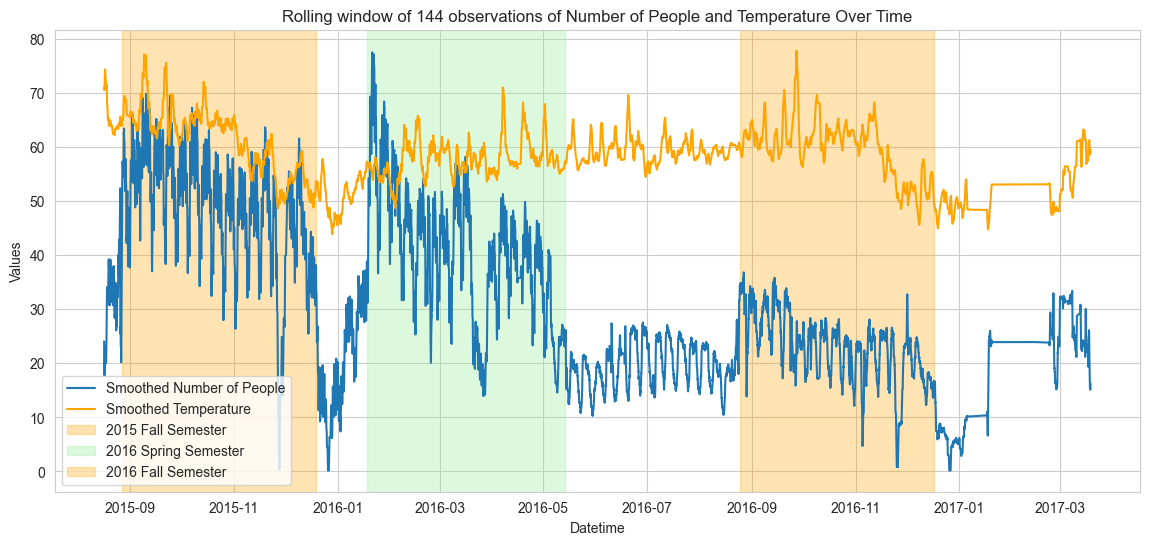

In [62]:
# Apply a rolling mean for smoothing
gym_data['number_people_smooth'] = gym_data['number_people'].rolling(window=144).mean()
gym_data['temperature_smooth'] = gym_data['temperature'].rolling(window=144).mean()

# Plotting the smoothed data as a function of the new datetime column
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data, x='datetime', y='number_people_smooth', label='Smoothed Number of People')
sns.lineplot(data=gym_data, x='datetime', y='temperature_smooth', label='Smoothed Temperature', color='orange')

# Define a color map for seasons
season_colors = {
    'Spring': 'lightgreen',
    'Summer': 'lightblue',
    'Fall': 'orange',
    'Winter': 'lightcoral'
}

# Helper function to determine the season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Modified function to determine the majority season of a semester
# This calculates how many days fall in each season and returns the season with the highest count.
def get_majority_season(start, end):
    days = pd.date_range(start=start, end=end, freq='D')
    season_counts = days.month.map(get_season).value_counts()
    majority_season = season_counts.idxmax()  # Find the season with the highest count
    return majority_season

# Highlight the time periods that are semesters and label them with year and season
for start, end in semester_intervals:
    season = get_majority_season(start, end)
    color = season_colors[season]
    label = f'{start.year} {season} Semester'

    plt.axvspan(start, end, color=color, alpha=0.3, label=label)

plt.title('Rolling window of 144 observations of Number of People and Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.show()

### Time series data
It appears from the data the gym was gradually losing people attending, and then in 2017, there was something going on, possibly renovations that prevented data collection for a few months. We observe the expected dips around the holidays, near Thanksgiving and Christmas

### Holidays
Let's check if the `is_holiday` column is giving us the right information

In [66]:
# Filter rows where 'is_holiday' is 1
holiday_dates = gym_data[gym_data['is_holiday'] == 1]['datetime'].dt.date

# Group by year and extract unique dates for holidays
holidays_per_year = holiday_dates.groupby(holiday_dates.map(lambda x: x.year)).unique()

# Display the unique holiday dates per year
for year, dates in holidays_per_year.items():
    print(f"Holidays in {year}: {list(dates)}")

Holidays in 2017: [datetime.date(2017, 1, 2), datetime.date(2017, 1, 3), datetime.date(2017, 1, 17)]


Interestingly the `is_holiday` column seems to be nonfunctional, We would expect more holidays than just those. We'll need to repair this column too.

We'll start with federal holidays. There's a good python module for this. We'll assume this is a US college for now, because we're observing a large dip at the end of november which corresponds to Thanksgiving, a US holiday.

```
pip install holidays
```

In [68]:
import holidays

# Initialize the US holidays
us_holidays = holidays.US()

gym_data['is_holiday_fixed'] = gym_data['datetime'].dt.date.apply(lambda x: x in us_holidays)

In [71]:
# Check the is_holiday_fixed column and extract holidays
fixed_holiday_dates = gym_data[gym_data['is_holiday_fixed'] == True]['datetime'].dt.date

# Group by year and list unique holidays per year
holidays_fixed_per_year = fixed_holiday_dates.groupby(fixed_holiday_dates.map(lambda x: x.year)).unique()

# Display the unique holiday dates and their names per year
for year, dates in holidays_fixed_per_year.items():
    holiday_names = [f"{date}: {us_holidays.get(date)}" for date in dates]
    print(f"Holidays in {year}: {holiday_names}")

Holidays in 2015: ['2015-09-07: Labor Day', '2015-11-11: Veterans Day', '2015-11-26: Thanksgiving', '2015-12-25: Christmas Day']
Holidays in 2016: ["2016-01-01: New Year's Day", '2016-01-18: Martin Luther King Jr. Day', "2016-02-15: Washington's Birthday", '2016-05-30: Memorial Day', '2016-07-04: Independence Day', '2016-09-05: Labor Day', '2016-11-11: Veterans Day', '2016-11-24: Thanksgiving', '2016-12-25: Christmas Day', '2016-12-26: Christmas Day (observed)']
Holidays in 2017: ["2017-01-01: New Year's Day", "2017-01-02: New Year's Day (observed)"]


Busiest Month: 2
Busiest Week: 5
Busiest Day: 2016-02-02


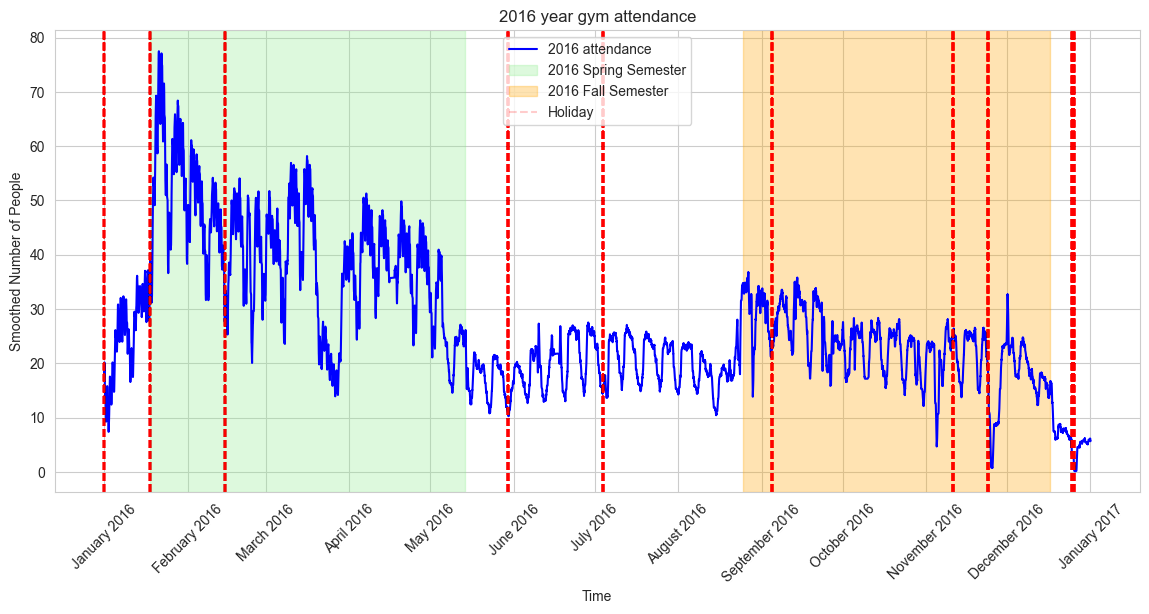

In [73]:
# Filter the dataset for the year 2016
gym_data_2016 = gym_data[gym_data['datetime'].dt.year == 2016]

# Identify the busiest month in 2016 based on the average number of people
busiest_month = gym_data_2016.groupby(gym_data_2016['datetime'].dt.month)['number_people'].mean().idxmax()
gym_data_busiest_month = gym_data_2016[gym_data_2016['datetime'].dt.month == busiest_month]

# Identify the busiest week in the busiest month
busiest_week = gym_data_busiest_month.groupby(gym_data_busiest_month['datetime'].dt.isocalendar().week)['number_people'].mean().idxmax()
gym_data_busiest_week = gym_data_busiest_month[gym_data_busiest_month['datetime'].dt.isocalendar().week == busiest_week]

# Identify the busiest day in the busiest week
busiest_day = gym_data_busiest_week.groupby(gym_data_busiest_week['datetime'].dt.date)['number_people'].mean().idxmax()
gym_data_busiest_day = gym_data_busiest_week[gym_data_busiest_week['datetime'].dt.date == busiest_day]

# Display results
print(f"Busiest Month: {busiest_month}")
print(f"Busiest Week: {busiest_week}")
print(f"Busiest Day: {busiest_day}")

# Visualization for the entire year 2016 with seasons and semester overlays
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_2016, x='datetime', y='number_people_smooth', label='2016 attendance', color='blue')

# Highlight the time periods that are semesters and label them with year and season
for start, end in semester_intervals:
    if start.year == 2016:  # Only include semesters for 2016
        season = get_majority_season(start, end)
        color = season_colors[season]
        label = f'{start.year} {season} Semester'
        plt.axvspan(start, end, color=color, alpha=0.3, label=label)

# Draw vertical bands for holidays
for holiday in fixed_holiday_dates:
    if holiday.year == 2016:  # Only include holidays for 2016
        plt.axvline(holiday, color='red', linestyle='--', alpha=0.2, label='Holiday' if 'Holiday' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('2016 year gym attendance')
plt.xlabel('Time')
plt.ylabel('Smoothed Number of People')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Show every month
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%B %Y'))  # Format as month name with year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

# 2016 insights
The 2016 plot with holidays marked out makes sense. We can observe some trends.
- That at start of the year and semester, attendance is high, which tails off as the semester completes. The fall semester duplicates this as well, but not as much
- There is a baseline level of gym attendance, likely provided by staff and students not returning home for summer holidays
- We also observe in the latter half of march a decline in attendance, likely coinciding with midterms and spring break.

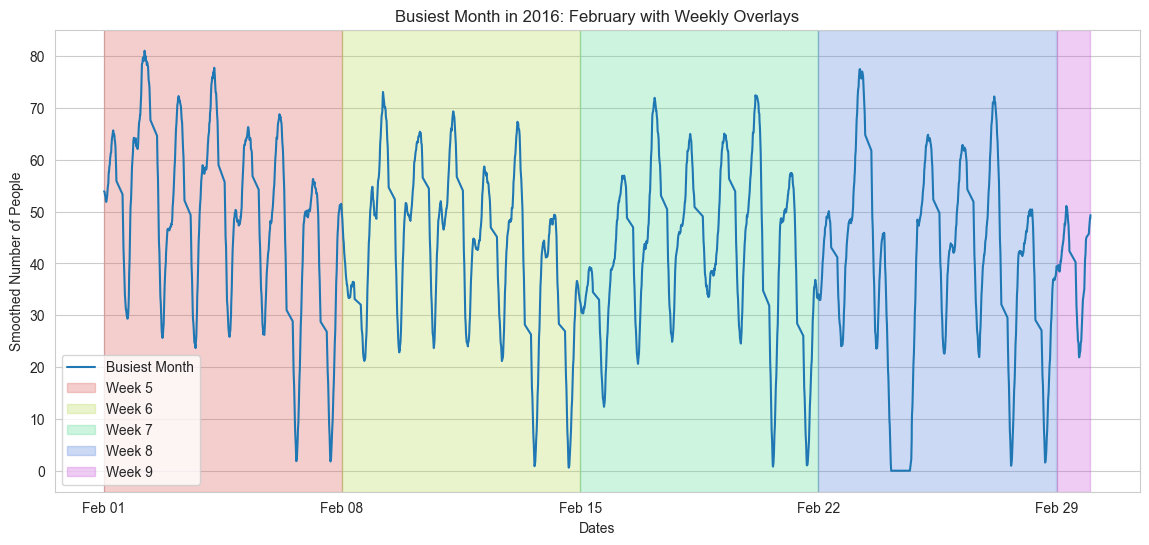

In [56]:
# Visualization for the Busiest Month
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_month, x='datetime', y='number_people_smooth', label='Busiest Month')

# Highlight different weeks with transparent overlays and alternating colors
unique_weeks = gym_data_busiest_month['datetime'].dt.isocalendar().week.unique()
colors = sns.color_palette("hls", len(unique_weeks))  # Generate unique colors

for i, week in enumerate(unique_weeks):
    week_data = gym_data_busiest_month[gym_data_busiest_month['datetime'].dt.isocalendar().week == week]
    start_date = week_data['datetime'].min()
    end_date = week_data['datetime'].max()
    plt.axvspan(start_date, end_date, color=colors[i], alpha=0.3, label=f'Week {week}')

# Adjust the x-axis to show correctly aligned ticks
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))  # Set ticks for every 7 days
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))  # Format as 'Month Day'

# Change the plot title to include the busiest month
busiest_month_name = pd.to_datetime(f'2016-{busiest_month}-01').strftime('%B')
plt.title(f'Busiest Month in 2016: {busiest_month_name} with Weekly Overlays')
plt.xlabel('Dates')
plt.ylabel('Smoothed Number of People')
plt.legend()
plt.show()

No data for Saturday at 12 PM in the busiest week.


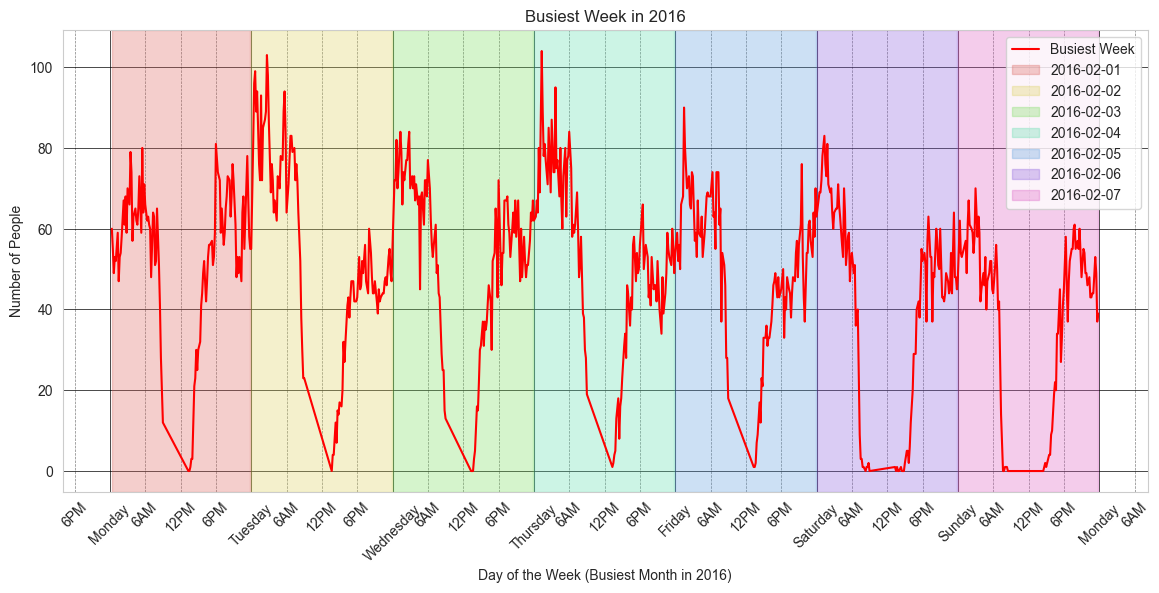

In [82]:
# Sanity check: How many people were in the gym on Saturday at 12 PM
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_week, x='datetime', y='number_people', label='Busiest Week', color='red')  # Use raw data

# Add colored overlays for individual days
unique_days = gym_data_busiest_week['datetime'].dt.date.unique()
colors = sns.color_palette("hls", len(unique_days))  # Generate unique colors for each day

for i, day in enumerate(unique_days):
    day_data = gym_data_busiest_week[gym_data_busiest_week['datetime'].dt.date == day]
    start_time = day_data['datetime'].min()
    end_time = day_data['datetime'].max()
    plt.axvspan(start_time, end_time, color=colors[i], alpha=0.3, label=f'{day}')

# Perform a sanity check for Saturday at 12 PM
saturday_12pm = gym_data_busiest_week[
    (gym_data_busiest_week['datetime'].dt.day_name() == 'Saturday') &
    (gym_data_busiest_week['datetime'].dt.hour == 12)
]
if not saturday_12pm.empty:
    people_at_12pm = saturday_12pm.iloc[0]['number_people']
    print(f"Number of people in the gym on Saturday at 12 PM: {people_at_12pm}")
else:
    print("No data for Saturday at 12 PM in the busiest week.")

plt.title('Busiest Week in 2016')
plt.xlabel('Day of the Week (Busiest Month in 2016)')
plt.ylabel('Number of People')  # Updated label

# Add major and minor ticks for the x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(byweekday=range(7)))  # Show all 7 days of week
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(byhour=[6,12,18]))  # Add minor ticks at 6am, 12pm and 6pm

# Add gridlines for both major and minor ticks
plt.grid(which='major', color='black', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Set custom labels for minor ticks
plt.gca().xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%#I%p'))  # Format minor ticks as '6am', '6pm'

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%A'))  # Format as day of the week
plt.xticks(rotation=45)  # Rotate major x-axis labels for better readability
plt.gca().tick_params(axis='x', which='minor', rotation=45)  # Rotate minor x-axis labels 90 degrees

plt.legend()
plt.show()

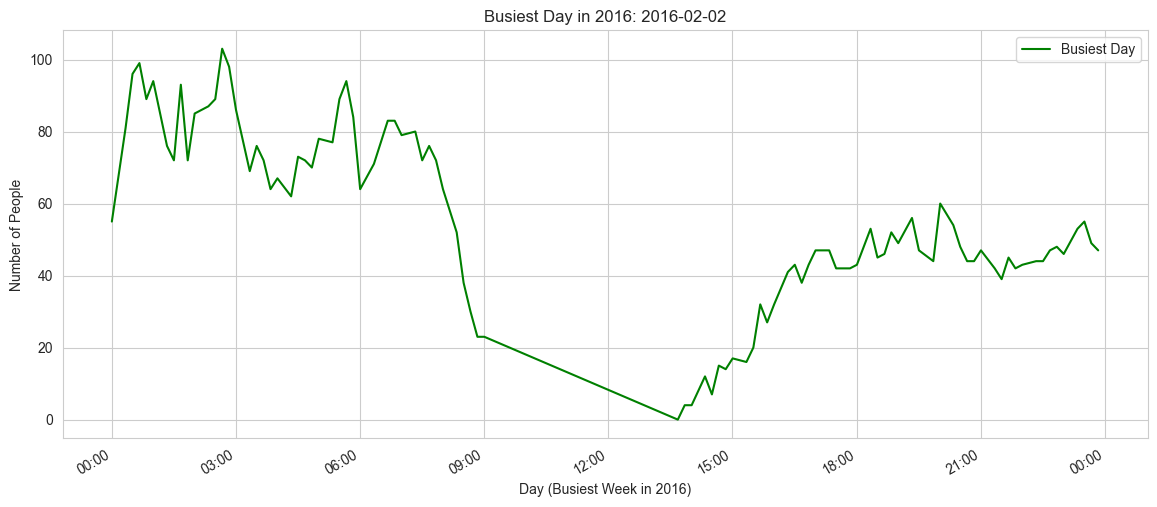

In [80]:
# Visualization for the Busiest Day
busiest_day_date = gym_data_busiest_day['datetime'].dt.date.unique()[0]  # Get the date of the busiest day
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_day, x='datetime', y='number_people', label='Busiest Day', color='green')
plt.title(f'Busiest Day in 2016: {busiest_day_date}')
plt.xlabel('Day (Busiest Week in 2016)')
plt.ylabel('Number of People')  # Reflect that raw data is being used
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()  # Auto format date to show time
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))  # Set x-axis format to hh:mm
plt.legend()
plt.show()

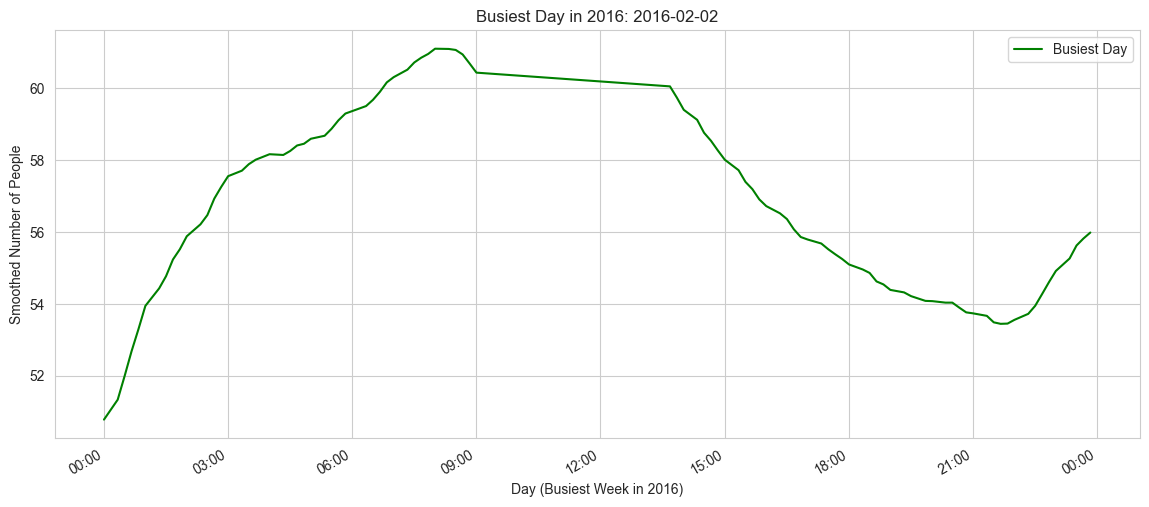

Sampled raw data for the busiest day (number of attendees and datetime, hourly):
                    datetime  number_people
0  2016-02-02 00:00:00+00:00           55.0
1  2016-02-02 01:00:00+00:00           94.0
2  2016-02-02 02:00:00+00:00           85.0
3  2016-02-02 03:00:00+00:00           86.0
4  2016-02-02 04:00:00+00:00           67.0
5  2016-02-02 05:00:00+00:00           78.0
6  2016-02-02 06:00:00+00:00           64.0
7  2016-02-02 07:00:00+00:00           79.0
8  2016-02-02 08:00:00+00:00           64.0
9  2016-02-02 09:00:00+00:00           23.0
10 2016-02-02 10:00:00+00:00            NaN
11 2016-02-02 11:00:00+00:00            NaN
12 2016-02-02 12:00:00+00:00            NaN
13 2016-02-02 13:00:00+00:00            0.0
14 2016-02-02 14:00:00+00:00            4.0
15 2016-02-02 15:00:00+00:00           17.0
16 2016-02-02 16:00:00+00:00           32.0
17 2016-02-02 17:00:00+00:00           47.0
18 2016-02-02 18:00:00+00:00           43.0
19 2016-02-02 19:00:00+00:00           

In [83]:
# Visualization for the Busiest Day
busiest_day_date = gym_data_busiest_day['datetime'].dt.date.unique()[0]  # Get the date of the busiest day
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_day, x='datetime', y='number_people_smooth', label='Busiest Day', color='green')
plt.title(f'Busiest Day in 2016: {busiest_day_date}')
plt.xlabel('Day (Busiest Week in 2016)')
plt.ylabel('Smoothed Number of People')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()  # Auto format date to show time
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))  # Set x-axis format to hh:mm
plt.legend()
plt.show()
# Show sampled raw data for observations on the busiest day (only number of attendees and datetime, sampled every hour)
print("Sampled raw data for the busiest day (number of attendees and datetime, hourly):")
sampled_data = gym_data_busiest_day.set_index('datetime').resample('h').first().reset_index()
print(sampled_data[['datetime', 'number_people']])

# EDA and data cleaning
We expect that `temperature` and `date` to be the two primary features. We'll keep the `is_holiday`, `isstartof_semester`, `is_during_semester` features as well, since we can't recreate those just from the `date` alone. Let's take a look at correlations for all of them first

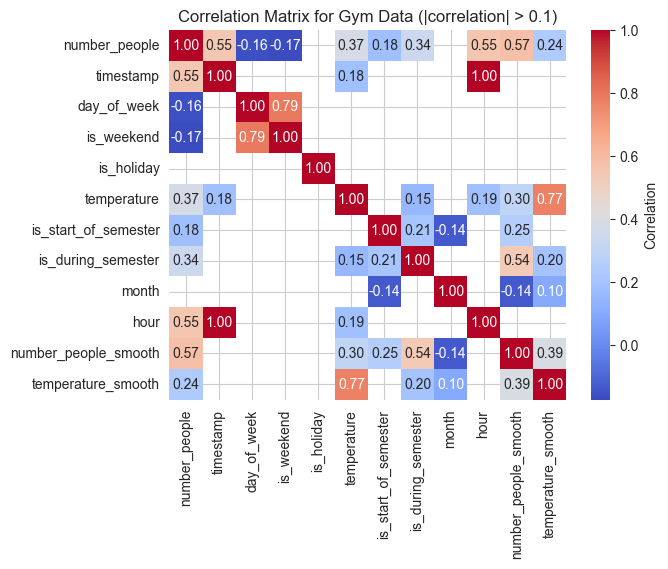

In [8]:
# Display correlation matrix of all numeric columns with correlations greater than 0.1 in absolute value
correlation_matrix = gym_data.select_dtypes(include=[np.number]).corr()

# Create a mask to filter out correlations with absolute values <= 0.1
mask = abs(correlation_matrix) <= 0.1

# Apply the mask before plotting
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar_kws={"label": "Correlation"})
plt.title('Correlation Matrix for Gym Data (|correlation| > 0.1)')
plt.show()

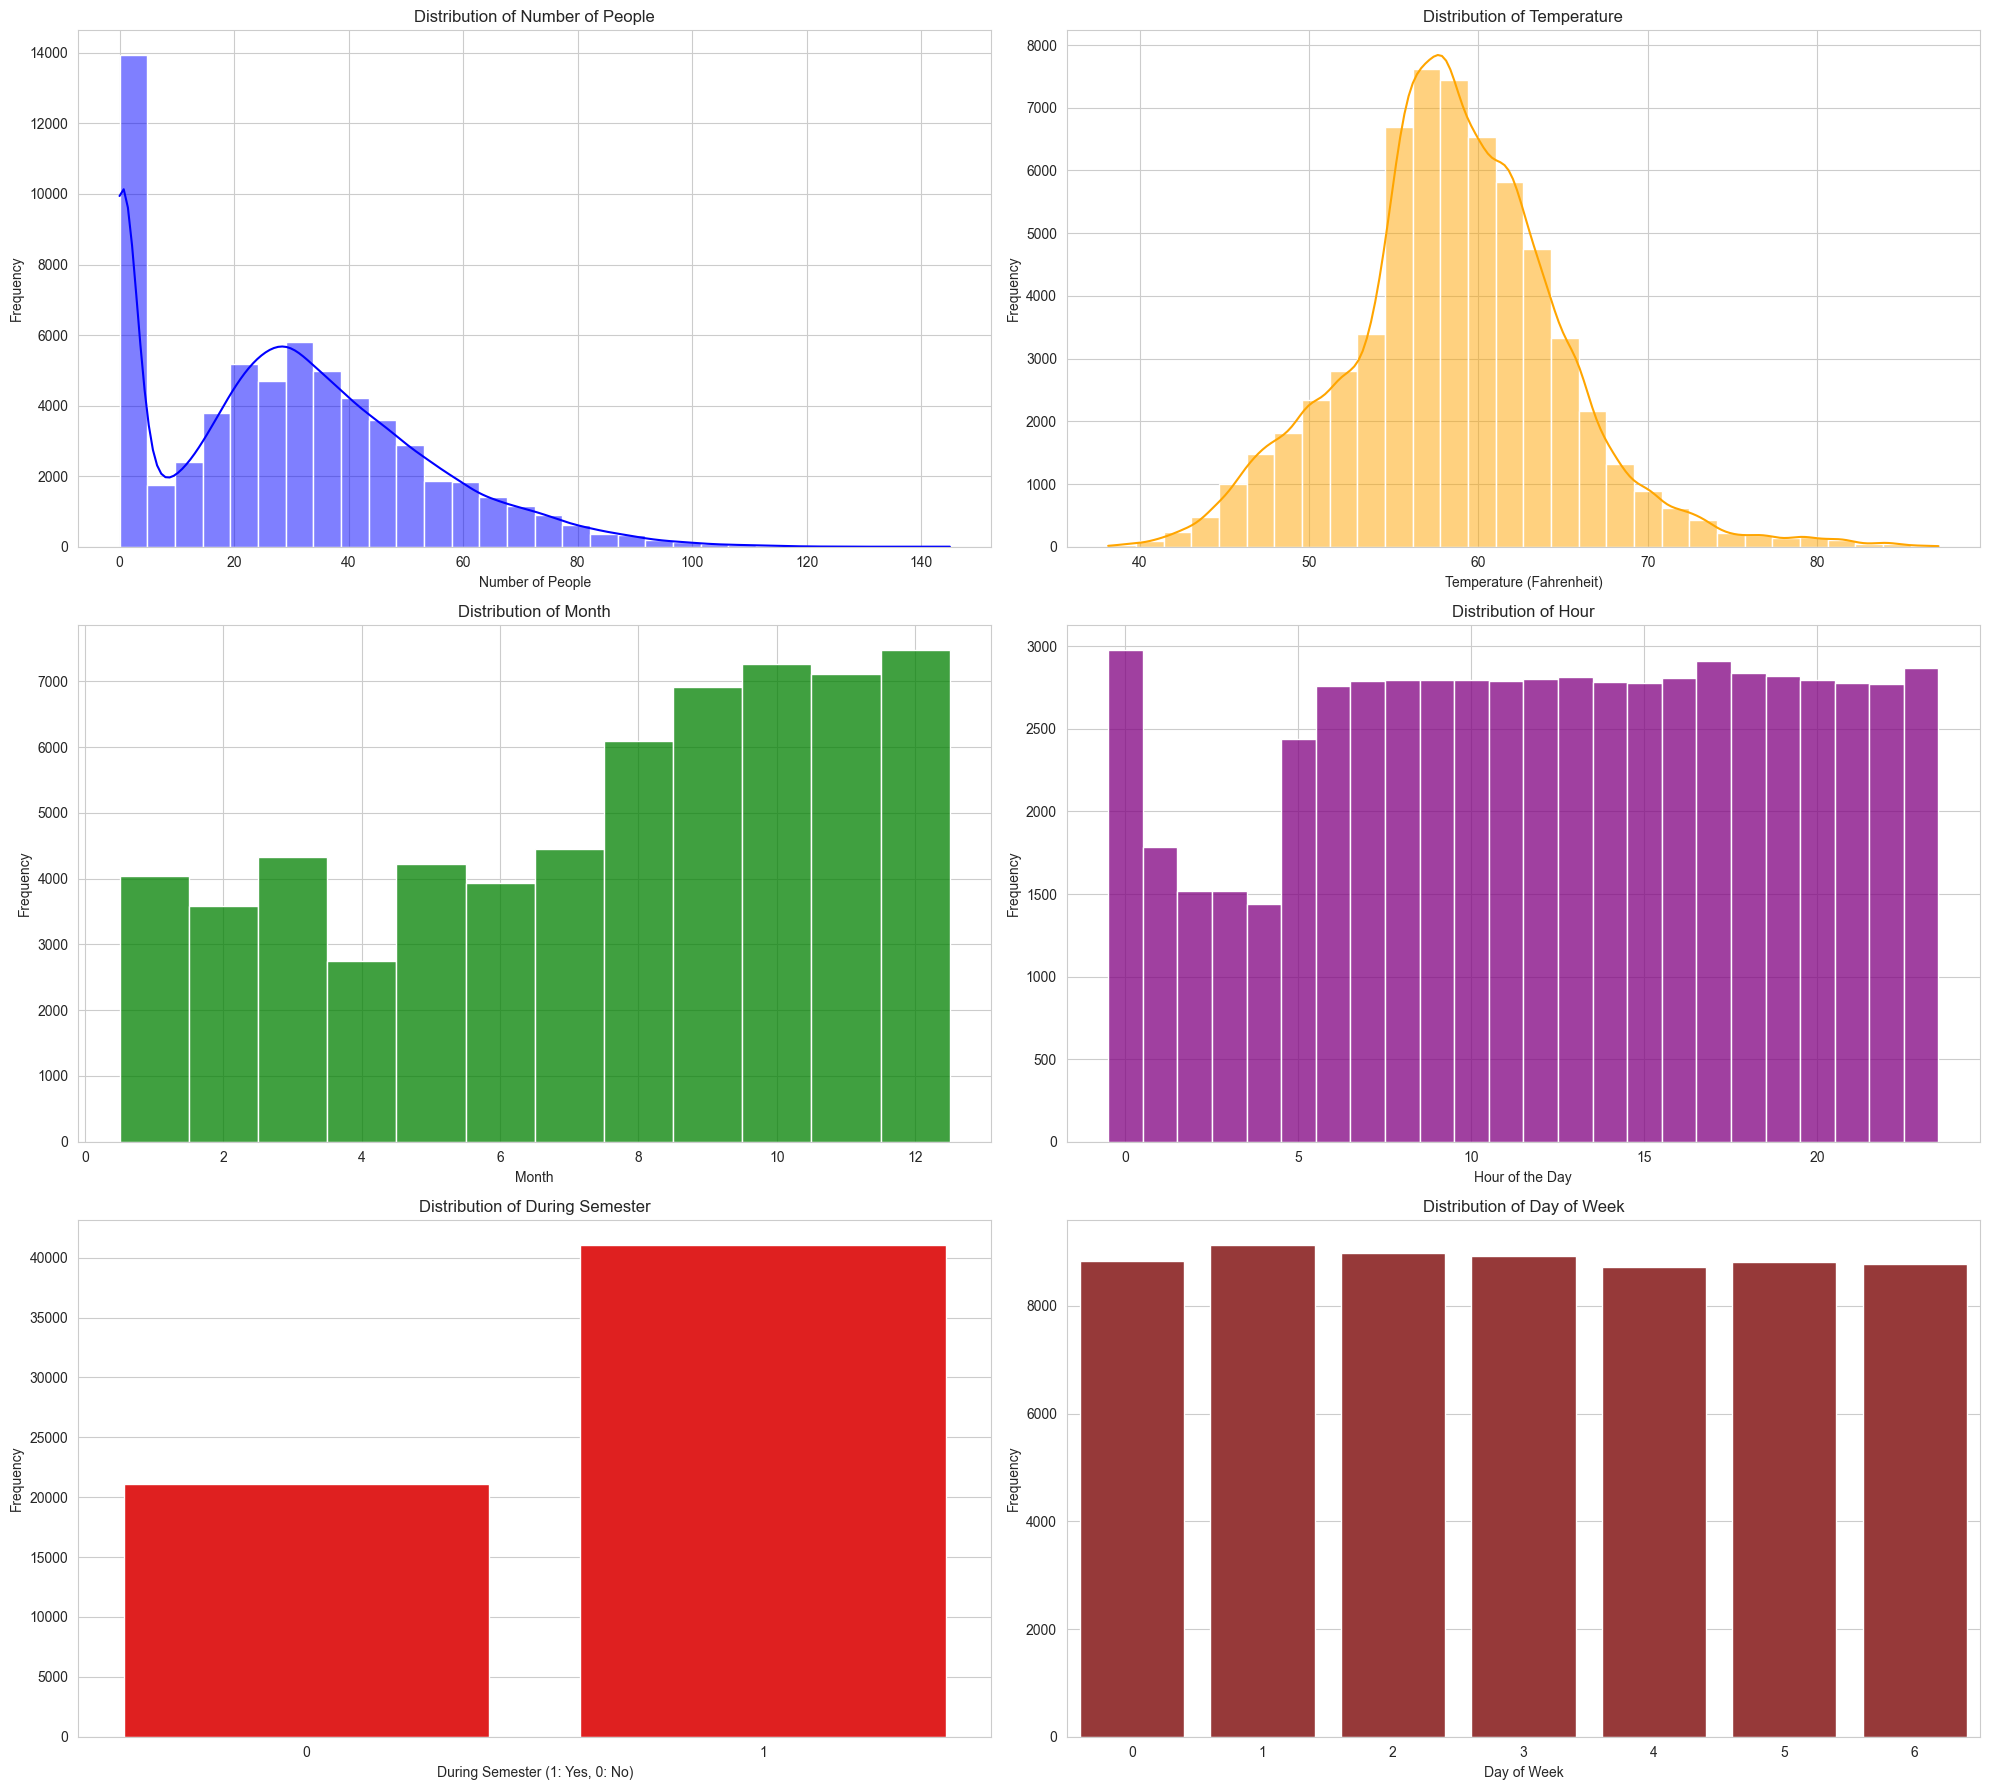

In [9]:
# Create a large figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

# Plotting the distribution of `number_people`
sns.histplot(gym_data['number_people'], bins=30, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Number of People')
axes[0, 0].set_xlabel('Number of People')
axes[0, 0].set_ylabel('Frequency')

# Plotting the distribution of `temperature`
sns.histplot(gym_data['temperature'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Temperature')
axes[0, 1].set_xlabel('Temperature (Fahrenheit)')
axes[0, 1].set_ylabel('Frequency')

# Plotting the distribution of `month`
sns.histplot(gym_data['month'], bins=12, discrete=True, kde=False, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Frequency')

# Plotting the distribution of `hour`
sns.histplot(gym_data['hour'], bins=24, discrete=True, kde=False, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Hour')
axes[1, 1].set_xlabel('Hour of the Day')
axes[1, 1].set_ylabel('Frequency')

# Plotting the distribution of `is_during_semester`
sns.countplot(x='is_during_semester', data=gym_data, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of During Semester')
axes[2, 0].set_xlabel('During Semester (1: Yes, 0: No)')
axes[2, 0].set_ylabel('Frequency')

# Plotting the distribution of `day_of_week`
sns.countplot(x='day_of_week', data=gym_data, color='brown', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Day of Week')
axes[2, 1].set_xlabel('Day of Week')
axes[2, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Distributions of features
- `number_of_people` shows a skewed distribution, where there's a number of distribution where the gym is empty (0 people)
- `temperature` distribution shows some skew, likely caused by the uneven number of observations in summer and winter months
- `month` distribution indicates substantially more observations form august to december
- `hour` distribution shows consistent observations except between midnight to 4am, where they are reduced.
- `is_during_semester` indicates that two thirds of the observations are in semester time.
- `day_of_week` indicates fairly normal distribution of observations

## Correlations
The number of people is strongly correlated with the `timestamp`, then `temperature`, then `is_during_semester`. To no great surprise, `timestamp` and `hour` are perfectly correlated. Interestingly, there is a slight negative correlation between attendance on a weekend. Suggesting students might travel home or off campus on weekends.

# Cleaning data
We'll want to build a data set that contains only the features we care about or think will predict the number of people well

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [11]:
gym_data_clean = gym_data.copy()
gym_data_clean.drop(columns=['date', 'datetime', 'timestamp'], inplace=True)

In [12]:
# Define features and target variable
X = gym_data_clean.drop(columns='number_people')
y = gym_data_clean['number_people']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (43528, 10)
Testing features shape: (18656, 10)
Training target shape: (43528,)
Testing target shape: (18656,)


In [13]:
# Create and fit the SGD Regressor to the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using huber loss function to deal with outliers
sgd_regressor = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor.fit(X_train_scaled, y_train)

ValueError: Input X contains NaN.
SGDRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [41]:
# Evaluate the model on the test set
y_pred = sgd_regressor.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 254.40612359797865
Mean Absolute Error: 12.041629235562851
R-squared: 0.5064269348641426


# Model performance
The mean absolute error indicates we get the number of people off by about 12, and R2 is only 50% correlated. This model is not performing well

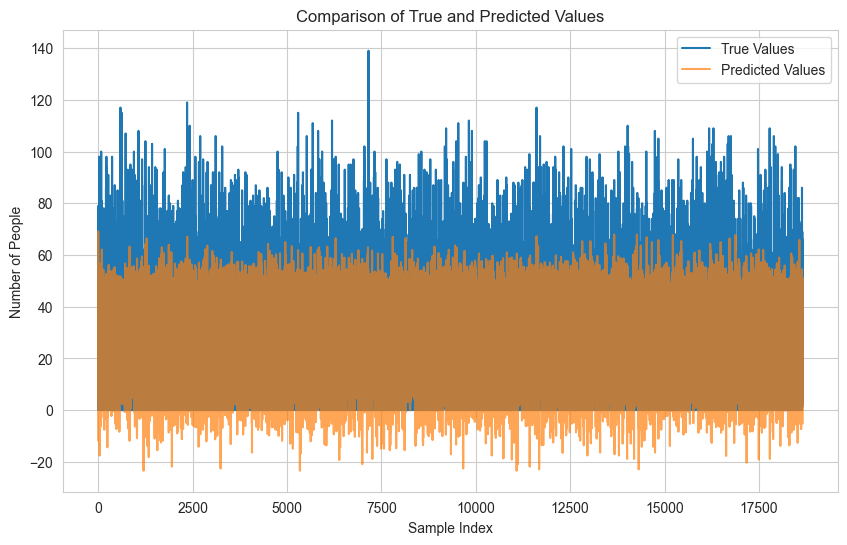

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred, label='Predicted Values', alpha=0.7)
plt.title('Comparison of True and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Number of People')
plt.legend()
plt.show()

The model is consistently predicting fewer people attending than actually did. We can try some hyperparameter optimisation, but stochastic gradient descent is probably the wrong tool for this problem.

## Hyperparameter optimisation

In [42]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [1000, 2000, 5000],
    'eta0': [0.01, 0.1],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Initialize GridSearchCV with the SGDRegressor and parameter grid for R-squared
grid_search_r2 = GridSearchCV(SGDRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search_r2.fit(X_train_scaled, y_train)

# Print the best parameters and the best R-squared score
print("Best parameters found (R-squared): ", grid_search_r2.best_params_)
print("Best R-squared score: ", grid_search_r2.best_score_)

C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\Dataquest.I

Best parameters found (R-squared):  {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'tol': 0.0001}
Best R-squared score:  0.5064669895948251


In [44]:
# Refit the model with the best parameters to extract feature weights
best_r2_model = grid_search_r2.best_estimator_
print("Feature weights with R-squared optimization:")
for feature_name, coef in zip(X_train.columns, best_r2_model.coef_):
    print(f"Feature {feature_name}: {coef}")

Feature weights with R-squared optimization:
Feature day_of_week: -1.7321372988893455
Feature is_weekend: -2.4495518522993316
Feature is_holiday: -0.6972980703462699
Feature temperature: 5.379760830766658
Feature is_start_of_semester: 1.8139964462480884
Feature is_during_semester: 5.951722169535055
Feature month: -2.6573766240175143
Feature hour: 11.21747727054455


# Optimisation results
Even after a fairly lengthy search of the hyperparameter optimisation space ,the delta for R2 initial guess and optimised ones is trivially small

# Model assumptions
Stochastic Gradient Descent assumes a linear relationship between features and target variable, in this case number of people at the gym. We're also encoding variables in time that are cyclical as linear. Let's try some cyclical encoding of them to see how they go

In [27]:
gym_data_clean2 = gym_data.copy()

# Cyclical encoding for 'hour'
gym_data_clean2['hour_sin'] = np.sin(2 * np.pi * gym_data_clean2['hour'] / 24)
gym_data_clean2['hour_cos'] = np.cos(2 * np.pi * gym_data_clean2['hour'] / 24)

# Cyclical encoding for 'month'
gym_data_clean2['month_sin'] = np.sin(2 * np.pi * gym_data_clean2['month'] / 12)
gym_data_clean2['month_cos'] = np.cos(2 * np.pi * gym_data_clean2['month'] / 12)

# Cyclical encoding for 'day_of_week'
gym_data_clean2['day_of_week_sin'] = np.sin(2 * np.pi * gym_data_clean2['day_of_week'] / 7)
gym_data_clean2['day_of_week_cos'] = np.cos(2 * np.pi * gym_data_clean2['day_of_week'] / 7)

In [28]:
gym_data_clean2.drop(columns=['date', 'datetime', 'timestamp'], inplace=True)

# Define features and target variable
X = gym_data_clean2.drop(columns='number_people')
y = gym_data_clean2['number_people']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

# Create and fit the SGD Regressor to the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using huber loss function to deal with outliers
sgd_regressor = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = sgd_regressor.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Model performance

Training features shape: (43528, 14)
Testing features shape: (18656, 14)
Training target shape: (43528,)
Testing target shape: (18656,)
Mean Squared Error: 224.95110069640867
Mean Absolute Error: 11.219316485002286
R-squared: 0.56357259524199


By moving to cyclical encoding we've improved the R2 and mean absolute error by orders of magnitude more than a hyperparameter search. It is likely this model can be improved by doing some additional feature engineering.

In [18]:
# List and show the coefficients and column names for the new model
print("Coefficients for the updated model with cyclical encoding:")
for feature_name, coef in zip(X_train.columns, sgd_regressor.coef_):
    print(f"Feature {feature_name}: {coef}")

Coefficients for the updated model with cyclical encoding:
Feature day_of_week: -1.3512232766425394
Feature is_weekend: -2.287794429368583
Feature is_holiday: -0.7344890710122802
Feature temperature: 2.56073857742821
Feature is_start_of_semester: 1.8593301445729697
Feature is_during_semester: 4.655564608021152
Feature month: -4.246896226170221
Feature hour: 7.041237431578332
Feature hour_sin: -5.835205567325157
Feature hour_cos: -5.148416463294928
Feature month_sin: -1.6107526750713845
Feature month_cos: 0.5167782019095434
Feature day_of_week_sin: 0.42073688891366867
Feature day_of_week_cos: -0.4221310854611473


In [50]:
# Create temporal aggregates
# Calculate average number of people for each hour, and day of the week
hourly_average = gym_data_clean2.groupby('hour')['number_people'].mean().reset_index(name='hourly_average')
daily_average = gym_data_clean2.groupby('day_of_week')['number_people'].mean().reset_index(name='daily_average')

# Merge these aggregates back to the original data
gym_data_clean2_with_aggregates = pd.merge(gym_data_clean2, hourly_average, on='hour', how='left')
gym_data_clean2_with_aggregates = pd.merge(gym_data_clean2_with_aggregates, daily_average, on='day_of_week', how='left')

# Define features and target variable with the new aggregates
X_with_aggregates = gym_data_clean2_with_aggregates.drop(columns='number_people')
y_with_aggregates = gym_data_clean2_with_aggregates['number_people']

# Split the data into training and testing sets
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_with_aggregates, y_with_aggregates, test_size=0.3, random_state=42)

# Scale the data
X_train_agg_scaled = scaler.fit_transform(X_train_agg)
X_test_agg_scaled = scaler.transform(X_test_agg)

# Use the SGD Regressor again with modified inputs
sgd_regressor_agg = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor_agg.fit(X_train_agg_scaled, y_train_agg)

# Evaluate the new model
y_pred_agg = sgd_regressor_agg.predict(X_test_agg_scaled)

# Calculate evaluation metrics for the new model
mse_agg = mean_squared_error(y_test_agg, y_pred_agg)
mae_agg = mean_absolute_error(y_test_agg, y_pred_agg)
r2_agg = r2_score(y_test_agg, y_pred_agg)

# Print the evaluation results
print("Mean Squared Error (with aggregates):", mse_agg)
print("Mean Absolute Error (with aggregates):", mae_agg)
print("R-squared (with aggregates):", r2_agg)

Mean Squared Error (with aggregates): 201.9890231667029
Mean Absolute Error (with aggregates): 10.515332457146016
R-squared (with aggregates): 0.6081212988185345


By applying some temporal aggregates we've improved the model again. It makes sense since any given gym session might be longer than 1 hour. We don't have enough good monthly data